## 필요한 라이브러리 import

In [1]:
# from pykospacing import Spacing
import pandas as pd
from konlpy.tag import Okt
from hanspell import spell_checker
import numpy as np
import re
import nltk
import gensim
from gensim import corpora
from gensim.models import wrappers
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric 
from gensim.models.callbacks import PerplexityMetric
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models

from konlpy.tag import Mecab 
from tqdm import tqdm 
import logging 
import pickle 


import matplotlib.pyplot as plt

mallet_path = '/home/inhaisc/.local/lib/python3.8/site-packages/gensim/models/wrappers/mallet-2.0.8/bin/mallet'
# spacing = Spacing()
okt = Okt()


## data.csv 파일 읽기 (tokenuztioned.csv 파일을 불러옴)

### 정수 인코딩과 단어 집합 만들기

In [2]:
df = pd.read_csv("post-data/tokeniztioned.csv",low_memory=False)
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english') # NLTK로부터 불용어를 받아옵니다.

for i in range(len(df)):
    try:
        df['token'][i] = df['token'][i].split() # 토큰화
    except:
        df['token'][i] = []
# tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = df['token']
tokenized_doc

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/inhaisc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipykernel_146013/3623081826.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['token'][i] = df['token'][i].split() # 토큰화
/tmp/ipykernel_146013/3623081826.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['token'][i] = []


0                    [조리, 유축]
1               [혼합, 분유, 하나요]
2            [신생아, 음식, 달라, 때]
3             [수술, 모유, 내일, 요]
4           [조리, 퇴소, 유축, 하나요]
                 ...         
13790             [냉동, 모유, 실]
13791          [아기, 때, 유, 축하]
13792             [가슴, 땅땅, 요]
13793        [남양, 아이엠, 마더, 분]
13794    [아기, 자고, 금방, 다음, 시간]
Name: token, Length: 13795, dtype: object

In [3]:
dictionary = corpora.Dictionary(tokenized_doc)
corpus = [dictionary.doc2bow(text) for text in tokenized_doc]
print(corpus[1]) # 수행된 결과에서 두번째 Doc 출력. 첫번째 문서의 인덱스는 0

[(2, 1), (3, 1), (4, 1)]


In [4]:
len(dictionary)

2323

In [5]:
token_list = []
index_list = []

for i in range(len(df)):
    index_list.append(i)
    try:
        token_list += df['token'][i]
#         print(f"{i} of {len(df['token'])}")
    except AttributeError:  # token이 없는 경우 예외처리
        print(f"ERROR!\n{i} : {df['token'][i]}")

print(f"중복 제거 전 : {len(token_list)}개")
token_list = list(set(token_list))
print(f"중복 제거 후 : {len(token_list)}개")

중복 제거 전 : 43778개
중복 제거 후 : 2323개


#### 총 2621개의 단어가 학습되었습니다. 이제 LDA 모델을 훈련시켜보겠습니다.

## LDA 모델 훈련시키기

In [18]:
NUM_TOPICS = 15 #15개의 토픽, k=15
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

2021-12-08 11:53:03,515 : INFO : using symmetric alpha at 0.06666666666666667
2021-12-08 11:53:03,516 : INFO : using symmetric eta at 0.06666666666666667
2021-12-08 11:53:03,517 : INFO : using serial LDA version on this node
2021-12-08 11:53:03,518 : INFO : running online (multi-pass) LDA training, 15 topics, 15 passes over the supplied corpus of 13795 documents, updating model once every 2000 documents, evaluating perplexity every 13795 documents, iterating 50x with a convergence threshold of 0.001000
2021-12-08 11:53:03,519 : INFO : PROGRESS: pass 0, at document #2000/13795
2021-12-08 11:53:03,746 : INFO : merging changes from 2000 documents into a model of 13795 documents
2021-12-08 11:53:03,747 : INFO : topic #7 (0.067): 0.095*"신생아" + 0.064*"텀" + 0.051*"후" + 0.051*"조리" + 0.044*"제왕절개" + 0.038*"맘" + 0.038*"젖" + 0.032*"고민" + 0.025*"초유" + 0.025*"가슴"
2021-12-08 11:53:03,748 : INFO : topic #3 (0.067): 0.096*"초유" + 0.052*"직수" + 0.048*"질문" + 0.034*"젖병" + 0.030*"조리" + 0.028*"음식" + 0.028*"포기

2021-12-08 11:53:04,830 : INFO : topic #2 (0.067): 0.132*"완불" + 0.094*"보관" + 0.093*"돌" + 0.089*"사출" + 0.063*"정체" + 0.057*"짜증" + 0.036*"유륜" + 0.033*"어떻게" + 0.032*"수로" + 0.026*"방귀"
2021-12-08 11:53:04,830 : INFO : topic diff=0.281672, rho=0.377964
2021-12-08 11:53:04,831 : INFO : PROGRESS: pass 1, at document #2000/13795
2021-12-08 11:53:04,982 : INFO : merging changes from 2000 documents into a model of 13795 documents
2021-12-08 11:53:04,984 : INFO : topic #12 (0.067): 0.325*"직수" + 0.236*"조리" + 0.135*"젖꼭지" + 0.035*"뭘" + 0.029*"사이즈" + 0.025*"처음" + 0.023*"퇴소" + 0.020*"개" + 0.016*"말" + 0.016*"이후"
2021-12-08 11:53:04,984 : INFO : topic #6 (0.067): 0.298*"유" + 0.178*"젖" + 0.076*"얼마나" + 0.062*"법" + 0.060*"축하" + 0.033*"공유" + 0.031*"이제" + 0.028*"횟수" + 0.028*"노" + 0.027*"발락"
2021-12-08 11:53:04,985 : INFO : topic #1 (0.067): 0.229*"생후" + 0.154*"직" + 0.105*"갑자기" + 0.067*"수하" + 0.041*"분" + 0.034*"수만" + 0.032*"계세" + 0.026*"신생아" + 0.024*"유방" + 0.019*"잠"
2021-12-08 11:53:04,986 : INFO : topic #0 (0.

2021-12-08 11:53:05,962 : INFO : topic diff=0.222512, rho=0.335248
2021-12-08 11:53:05,963 : INFO : PROGRESS: pass 2, at document #2000/13795
2021-12-08 11:53:06,093 : INFO : merging changes from 2000 documents into a model of 13795 documents
2021-12-08 11:53:06,095 : INFO : topic #13 (0.067): 0.201*"후" + 0.085*"제왕절개" + 0.072*"약" + 0.066*"조언" + 0.055*"몸무게" + 0.055*"밤" + 0.052*"전" + 0.044*"새벽" + 0.042*"조리" + 0.038*"퇴소"
2021-12-08 11:53:06,095 : INFO : topic #12 (0.067): 0.336*"직수" + 0.245*"조리" + 0.133*"젖꼭지" + 0.034*"뭘" + 0.030*"백일" + 0.029*"사이즈" + 0.025*"처음" + 0.023*"퇴소" + 0.020*"개" + 0.016*"말"
2021-12-08 11:53:06,096 : INFO : topic #0 (0.067): 0.266*"완모" + 0.109*"하루" + 0.069*"방법" + 0.062*"트림" + 0.054*"엄마" + 0.049*"우유" + 0.047*"통증" + 0.041*"달" + 0.035*"물어" + 0.026*"번"
2021-12-08 11:53:06,097 : INFO : topic #10 (0.067): 0.244*"분" + 0.202*"유량" + 0.184*"좀" + 0.093*"건가" + 0.044*"먹이" + 0.044*"한쪽" + 0.028*"전량" + 0.018*"냉동" + 0.017*"스트레스" + 0.017*"황달"
2021-12-08 11:53:06,097 : INFO : topic #14

2021-12-08 11:53:07,078 : INFO : merging changes from 2000 documents into a model of 13795 documents
2021-12-08 11:53:07,079 : INFO : topic #11 (0.067): 0.334*"때" + 0.237*"질문" + 0.184*"혼합" + 0.030*"이오" + 0.026*"중" + 0.024*"첫" + 0.024*"밤중" + 0.017*"소리" + 0.016*"병원" + 0.015*"조금"
2021-12-08 11:53:07,080 : INFO : topic #9 (0.067): 0.233*"유두" + 0.194*"거부" + 0.079*"토" + 0.064*"보호" + 0.062*"젖병" + 0.035*"달라" + 0.030*"수도" + 0.028*"함몰" + 0.027*"다른" + 0.025*"분수"
2021-12-08 11:53:07,080 : INFO : topic #10 (0.067): 0.250*"분" + 0.206*"유량" + 0.184*"좀" + 0.092*"건가" + 0.044*"먹이" + 0.043*"한쪽" + 0.028*"전량" + 0.018*"냉동" + 0.017*"스트레스" + 0.017*"황달"
2021-12-08 11:53:07,081 : INFO : topic #4 (0.067): 0.151*"거" + 0.142*"마사지" + 0.104*"자" + 0.067*"유선" + 0.054*"한번" + 0.053*"번" + 0.048*"오늘" + 0.046*"도움" + 0.036*"이요" + 0.035*"중탕"
2021-12-08 11:53:07,082 : INFO : topic #8 (0.067): 0.218*"출산" + 0.200*"가슴" + 0.194*"하나요" + 0.079*"제왕" + 0.068*"후" + 0.063*"계속" + 0.052*"차" + 0.037*"젖" + 0.018*"느낌" + 0.017*"생리"
2021-12-08

2021-12-08 11:53:08,073 : INFO : topic #7 (0.067): 0.098*"텀" + 0.095*"단계" + 0.081*"맘" + 0.070*"언제" + 0.064*"타밀" + 0.064*"압" + 0.058*"아이" + 0.046*"고민" + 0.040*"가요" + 0.034*"왜"
2021-12-08 11:53:08,074 : INFO : topic #2 (0.067): 0.155*"완불" + 0.084*"사출" + 0.075*"돌" + 0.071*"보관" + 0.055*"정체" + 0.051*"자연" + 0.049*"짜증" + 0.048*"기" + 0.038*"어떻게" + 0.036*"수로"
2021-12-08 11:53:08,075 : INFO : topic #10 (0.067): 0.250*"분" + 0.208*"유량" + 0.184*"좀" + 0.091*"건가" + 0.043*"먹이" + 0.042*"한쪽" + 0.027*"전량" + 0.018*"냉동" + 0.017*"스트레스" + 0.016*"황달"
2021-12-08 11:53:08,075 : INFO : topic #3 (0.067): 0.217*"초유" + 0.169*"젖병" + 0.123*"음식" + 0.071*"뭐" + 0.051*"문의" + 0.036*"두" + 0.029*"시" + 0.028*"초보" + 0.027*"저" + 0.027*"물리"
2021-12-08 11:53:08,076 : INFO : topic diff=0.134387, rho=0.289916
2021-12-08 11:53:08,076 : INFO : PROGRESS: pass 4, at document #4000/13795
2021-12-08 11:53:08,184 : INFO : merging changes from 2000 documents into a model of 13795 documents
2021-12-08 11:53:08,185 : INFO : topic #12 (0.067

2021-12-08 11:53:09,037 : INFO : topic #2 (0.067): 0.156*"완불" + 0.083*"사출" + 0.076*"돌" + 0.070*"보관" + 0.056*"정체" + 0.050*"기" + 0.050*"자연" + 0.049*"짜증" + 0.037*"어떻게" + 0.036*"지난"
2021-12-08 11:53:09,038 : INFO : topic #8 (0.067): 0.216*"출산" + 0.203*"가슴" + 0.197*"하나요" + 0.078*"제왕" + 0.069*"후" + 0.063*"계속" + 0.053*"차" + 0.037*"젖" + 0.018*"느낌" + 0.018*"생리"
2021-12-08 11:53:09,038 : INFO : topic #0 (0.067): 0.275*"완모" + 0.116*"하루" + 0.070*"방법" + 0.062*"트림" + 0.054*"엄마" + 0.051*"우유" + 0.047*"통증" + 0.045*"달" + 0.035*"물어" + 0.029*"젖꼭지종류"
2021-12-08 11:53:09,039 : INFO : topic diff=0.122531, rho=0.278450
2021-12-08 11:53:09,039 : INFO : PROGRESS: pass 5, at document #4000/13795
2021-12-08 11:53:09,159 : INFO : merging changes from 2000 documents into a model of 13795 documents
2021-12-08 11:53:09,160 : INFO : topic #6 (0.067): 0.287*"유" + 0.184*"젖" + 0.096*"얼마나" + 0.060*"법" + 0.059*"축하" + 0.054*"공유" + 0.036*"이제" + 0.030*"횟수" + 0.022*"노" + 0.022*"발락"
2021-12-08 11:53:09,161 : INFO : topic #9 (0.

2021-12-08 11:53:10,011 : INFO : topic #13 (0.067): 0.227*"후" + 0.079*"제왕절개" + 0.069*"약" + 0.066*"조언" + 0.059*"몸무게" + 0.056*"밤" + 0.051*"전" + 0.043*"새벽" + 0.037*"조리" + 0.036*"자주"
2021-12-08 11:53:10,012 : INFO : topic #11 (0.067): 0.332*"때" + 0.237*"질문" + 0.187*"혼합" + 0.030*"이오" + 0.026*"중" + 0.025*"밤중" + 0.023*"첫" + 0.017*"소리" + 0.016*"조금" + 0.015*"병원"
2021-12-08 11:53:10,012 : INFO : topic diff=0.116551, rho=0.268245
2021-12-08 11:53:10,013 : INFO : PROGRESS: pass 6, at document #4000/13795
2021-12-08 11:53:10,123 : INFO : merging changes from 2000 documents into a model of 13795 documents
2021-12-08 11:53:10,124 : INFO : topic #11 (0.067): 0.295*"때" + 0.259*"질문" + 0.197*"혼합" + 0.035*"이오" + 0.029*"중" + 0.029*"첫" + 0.023*"밤중" + 0.016*"이용" + 0.016*"왕분" + 0.014*"병원"
2021-12-08 11:53:10,125 : INFO : topic #13 (0.067): 0.236*"후" + 0.095*"제왕절개" + 0.070*"조언" + 0.054*"약" + 0.053*"몸무게" + 0.049*"전" + 0.048*"밤" + 0.045*"조리" + 0.045*"퇴소" + 0.043*"새벽"
2021-12-08 11:53:10,125 : INFO : topic #6 (0.

2021-12-08 11:53:10,974 : INFO : topic #4 (0.067): 0.158*"마사지" + 0.149*"거" + 0.100*"자" + 0.067*"유선" + 0.055*"번" + 0.054*"한번" + 0.046*"오늘" + 0.044*"도움" + 0.037*"이요" + 0.034*"중탕"
2021-12-08 11:53:10,975 : INFO : topic diff=0.111609, rho=0.259086
2021-12-08 11:53:10,976 : INFO : PROGRESS: pass 7, at document #4000/13795
2021-12-08 11:53:11,096 : INFO : merging changes from 2000 documents into a model of 13795 documents
2021-12-08 11:53:11,097 : INFO : topic #7 (0.067): 0.131*"텀" + 0.082*"단계" + 0.074*"맘" + 0.072*"언제" + 0.059*"아이" + 0.054*"타밀" + 0.053*"압" + 0.051*"고민" + 0.039*"가요" + 0.035*"왜"
2021-12-08 11:53:11,098 : INFO : topic #9 (0.067): 0.236*"유두" + 0.212*"거부" + 0.078*"토" + 0.059*"보호" + 0.059*"젖병" + 0.035*"달라" + 0.026*"수도" + 0.025*"함몰" + 0.024*"다른" + 0.024*"사용"
2021-12-08 11:53:11,099 : INFO : topic #2 (0.067): 0.185*"완불" + 0.084*"사출" + 0.062*"자연" + 0.062*"돌" + 0.056*"보관" + 0.053*"주" + 0.049*"정체" + 0.048*"기" + 0.043*"짜증" + 0.033*"지난"
2021-12-08 11:53:11,099 : INFO : topic #14 (0.067):

2021-12-08 11:53:11,925 : INFO : topic diff=0.107237, rho=0.250805
2021-12-08 11:53:11,926 : INFO : PROGRESS: pass 8, at document #4000/13795
2021-12-08 11:53:12,042 : INFO : merging changes from 2000 documents into a model of 13795 documents
2021-12-08 11:53:12,043 : INFO : topic #10 (0.067): 0.245*"분" + 0.244*"유량" + 0.185*"좀" + 0.085*"건가" + 0.037*"먹이" + 0.033*"한쪽" + 0.022*"전량" + 0.019*"스트레스" + 0.019*"황달" + 0.014*"패턴"
2021-12-08 11:53:12,044 : INFO : topic #1 (0.067): 0.374*"생후" + 0.149*"직" + 0.086*"갑자기" + 0.070*"수하" + 0.031*"수만" + 0.026*"계세" + 0.022*"유방" + 0.022*"달" + 0.018*"자고" + 0.016*"유즙"
2021-12-08 11:53:12,044 : INFO : topic #3 (0.067): 0.249*"초유" + 0.163*"젖병" + 0.126*"음식" + 0.068*"뭐" + 0.046*"문의" + 0.031*"포기" + 0.030*"물리" + 0.029*"두" + 0.029*"킬로" + 0.026*"시"
2021-12-08 11:53:12,045 : INFO : topic #5 (0.067): 0.507*"신생아" + 0.070*"보충" + 0.046*"변" + 0.041*"이유식" + 0.040*"바로" + 0.035*"텀이" + 0.028*"히프" + 0.028*"때문" + 0.027*"배앓이" + 0.019*"일주일"
2021-12-08 11:53:12,046 : INFO : topic #1

2021-12-08 11:53:13,017 : INFO : merging changes from 2000 documents into a model of 13795 documents
2021-12-08 11:53:13,018 : INFO : topic #1 (0.067): 0.372*"생후" + 0.149*"직" + 0.087*"갑자기" + 0.069*"수하" + 0.031*"수만" + 0.026*"계세" + 0.022*"유방" + 0.021*"달" + 0.018*"자고" + 0.016*"유즙"
2021-12-08 11:53:13,019 : INFO : topic #9 (0.067): 0.234*"유두" + 0.215*"거부" + 0.078*"토" + 0.060*"젖병" + 0.058*"보호" + 0.035*"달라" + 0.026*"수도" + 0.024*"다른" + 0.024*"함몰" + 0.024*"사용"
2021-12-08 11:53:13,019 : INFO : topic #12 (0.067): 0.348*"직수" + 0.271*"조리" + 0.119*"젖꼭지" + 0.028*"백일" + 0.028*"처음" + 0.026*"뭘" + 0.025*"사이즈" + 0.023*"퇴소" + 0.018*"말" + 0.017*"개"
2021-12-08 11:53:13,020 : INFO : topic #2 (0.067): 0.184*"완불" + 0.084*"사출" + 0.064*"돌" + 0.061*"자연" + 0.057*"보관" + 0.051*"주" + 0.050*"정체" + 0.048*"기" + 0.043*"짜증" + 0.034*"지난"
2021-12-08 11:53:13,020 : INFO : topic #10 (0.067): 0.245*"분" + 0.244*"유량" + 0.185*"좀" + 0.085*"건가" + 0.037*"먹이" + 0.033*"한쪽" + 0.022*"전량" + 0.019*"스트레스" + 0.019*"황달" + 0.014*"패턴"
2021-12-

2021-12-08 11:53:13,993 : INFO : topic #12 (0.067): 0.348*"직수" + 0.268*"조리" + 0.120*"젖꼭지" + 0.029*"백일" + 0.028*"처음" + 0.026*"뭘" + 0.025*"사이즈" + 0.023*"퇴소" + 0.018*"말" + 0.017*"개"
2021-12-08 11:53:13,994 : INFO : topic #8 (0.067): 0.249*"출산" + 0.182*"하나요" + 0.176*"가슴" + 0.086*"제왕" + 0.074*"후" + 0.063*"차" + 0.056*"계속" + 0.032*"젖" + 0.020*"병원" + 0.017*"느낌"
2021-12-08 11:53:13,995 : INFO : topic #5 (0.067): 0.499*"신생아" + 0.070*"보충" + 0.047*"변" + 0.044*"이유식" + 0.040*"바로" + 0.035*"텀이" + 0.029*"히프" + 0.028*"때문" + 0.027*"배앓이" + 0.019*"일주일"
2021-12-08 11:53:13,995 : INFO : topic #10 (0.067): 0.245*"분" + 0.244*"유량" + 0.185*"좀" + 0.084*"건가" + 0.037*"먹이" + 0.033*"한쪽" + 0.022*"전량" + 0.019*"스트레스" + 0.019*"황달" + 0.014*"패턴"
2021-12-08 11:53:13,996 : INFO : topic diff=0.067139, rho=0.236376
2021-12-08 11:53:13,996 : INFO : PROGRESS: pass 10, at document #6000/13795
2021-12-08 11:53:14,098 : INFO : merging changes from 2000 documents into a model of 13795 documents
2021-12-08 11:53:14,099 : INFO : topic

2021-12-08 11:53:14,933 : INFO : topic #14 (0.067): 0.128*"추천" + 0.126*"위치" + 0.090*"해" + 0.087*"몸살" + 0.070*"통" + 0.058*"지금" + 0.051*"단" + 0.035*"곧" + 0.032*"외출" + 0.027*"반수"
2021-12-08 11:53:14,934 : INFO : topic #10 (0.067): 0.245*"분" + 0.245*"유량" + 0.185*"좀" + 0.084*"건가" + 0.037*"먹이" + 0.033*"한쪽" + 0.022*"전량" + 0.019*"스트레스" + 0.018*"황달" + 0.014*"패턴"
2021-12-08 11:53:14,934 : INFO : topic #0 (0.067): 0.247*"완모" + 0.124*"하루" + 0.070*"방법" + 0.070*"달" + 0.059*"트림" + 0.053*"통증" + 0.047*"엄마" + 0.043*"우유" + 0.036*"물어" + 0.029*"번"
2021-12-08 11:53:14,935 : INFO : topic diff=0.065811, rho=0.230037
2021-12-08 11:53:14,936 : INFO : PROGRESS: pass 11, at document #6000/13795
2021-12-08 11:53:15,040 : INFO : merging changes from 2000 documents into a model of 13795 documents
2021-12-08 11:53:15,042 : INFO : topic #5 (0.067): 0.450*"신생아" + 0.073*"보충" + 0.052*"변" + 0.051*"텀이" + 0.042*"이유식" + 0.041*"바로" + 0.031*"반" + 0.030*"때문" + 0.028*"배앓이" + 0.028*"히프"
2021-12-08 11:53:15,043 : INFO : topic #3 (

2021-12-08 11:53:15,928 : INFO : topic #9 (0.067): 0.230*"유두" + 0.218*"거부" + 0.079*"토" + 0.062*"젖병" + 0.057*"보호" + 0.035*"달라" + 0.026*"수도" + 0.024*"다른" + 0.024*"함몰" + 0.023*"사용"
2021-12-08 11:53:15,928 : INFO : topic #7 (0.067): 0.128*"텀" + 0.085*"단계" + 0.074*"맘" + 0.070*"언제" + 0.060*"아이" + 0.055*"타밀" + 0.054*"압" + 0.050*"고민" + 0.039*"가요" + 0.035*"왜"
2021-12-08 11:53:15,929 : INFO : topic diff=0.063937, rho=0.224182
2021-12-08 11:53:15,929 : INFO : PROGRESS: pass 12, at document #6000/13795
2021-12-08 11:53:16,033 : INFO : merging changes from 2000 documents into a model of 13795 documents
2021-12-08 11:53:16,034 : INFO : topic #13 (0.067): 0.217*"후" + 0.088*"몸무게" + 0.078*"조언" + 0.073*"제왕절개" + 0.053*"밤" + 0.050*"약" + 0.048*"전" + 0.045*"새벽" + 0.035*"조리" + 0.035*"퇴소"
2021-12-08 11:53:16,035 : INFO : topic #7 (0.067): 0.164*"텀" + 0.080*"단계" + 0.072*"맘" + 0.062*"언제" + 0.061*"아이" + 0.051*"고민" + 0.048*"타밀" + 0.048*"압" + 0.039*"왜" + 0.036*"가요"
2021-12-08 11:53:16,036 : INFO : topic #14 (0.067

2021-12-08 11:53:16,899 : INFO : topic #7 (0.067): 0.128*"텀" + 0.086*"단계" + 0.074*"맘" + 0.070*"언제" + 0.060*"아이" + 0.055*"타밀" + 0.054*"압" + 0.050*"고민" + 0.039*"가요" + 0.035*"왜"
2021-12-08 11:53:16,900 : INFO : topic diff=0.062612, rho=0.218752
2021-12-08 11:53:16,901 : INFO : PROGRESS: pass 13, at document #6000/13795
2021-12-08 11:53:17,000 : INFO : merging changes from 2000 documents into a model of 13795 documents
2021-12-08 11:53:17,001 : INFO : topic #13 (0.067): 0.217*"후" + 0.087*"몸무게" + 0.077*"조언" + 0.073*"제왕절개" + 0.054*"밤" + 0.050*"약" + 0.048*"전" + 0.045*"새벽" + 0.035*"조리" + 0.035*"퇴소"
2021-12-08 11:53:17,002 : INFO : topic #5 (0.067): 0.447*"신생아" + 0.073*"보충" + 0.053*"변" + 0.050*"텀이" + 0.043*"이유식" + 0.041*"바로" + 0.031*"때문" + 0.030*"반" + 0.028*"배앓이" + 0.028*"히프"
2021-12-08 11:53:17,003 : INFO : topic #10 (0.067): 0.276*"유량" + 0.237*"분" + 0.188*"좀" + 0.073*"건가" + 0.036*"먹이" + 0.030*"한쪽" + 0.020*"전량" + 0.018*"스트레스" + 0.016*"패턴" + 0.016*"황달"
2021-12-08 11:53:17,003 : INFO : topic #9 

2021-12-08 11:53:17,853 : INFO : topic diff=0.061359, rho=0.213699
2021-12-08 11:53:17,854 : INFO : PROGRESS: pass 14, at document #6000/13795
2021-12-08 11:53:17,960 : INFO : merging changes from 2000 documents into a model of 13795 documents
2021-12-08 11:53:17,961 : INFO : topic #14 (0.067): 0.119*"위치" + 0.118*"추천" + 0.096*"해" + 0.084*"통" + 0.076*"몸살" + 0.057*"지금" + 0.047*"단" + 0.036*"곧" + 0.034*"반수" + 0.031*"냥"
2021-12-08 11:53:17,962 : INFO : topic #0 (0.067): 0.250*"완모" + 0.151*"하루" + 0.098*"달" + 0.059*"방법" + 0.051*"트림" + 0.040*"엄마" + 0.040*"통증" + 0.034*"번" + 0.033*"우유" + 0.028*"여"
2021-12-08 11:53:17,962 : INFO : topic #13 (0.067): 0.217*"후" + 0.087*"몸무게" + 0.077*"조언" + 0.072*"제왕절개" + 0.054*"밤" + 0.051*"약" + 0.049*"전" + 0.045*"새벽" + 0.035*"조리" + 0.035*"퇴소"
2021-12-08 11:53:17,963 : INFO : topic #6 (0.067): 0.268*"유" + 0.166*"젖" + 0.103*"얼마나" + 0.092*"공유" + 0.056*"법" + 0.048*"축하" + 0.041*"횟수" + 0.036*"이제" + 0.023*"체중" + 0.022*"노"
2021-12-08 11:53:17,963 : INFO : topic #12 (0.067)

(0, '0.291*"완모" + 0.124*"하루" + 0.068*"방법" + 0.060*"우유"')
(1, '0.231*"생후" + 0.162*"직" + 0.138*"갑자기" + 0.071*"수하"')
(2, '0.157*"완불" + 0.093*"돌" + 0.084*"사출" + 0.077*"보관"')
(3, '0.223*"젖병" + 0.161*"음식" + 0.108*"초유" + 0.083*"뭐"')
(4, '0.170*"마사지" + 0.168*"거" + 0.074*"유선" + 0.071*"자"')
(5, '0.238*"신생아" + 0.107*"이유식" + 0.093*"보충" + 0.078*"변"')
(6, '0.307*"유" + 0.156*"젖" + 0.082*"얼마나" + 0.068*"법"')
(7, '0.108*"단계" + 0.098*"텀" + 0.074*"맘" + 0.069*"타밀"')
(8, '0.247*"하나요" + 0.245*"가슴" + 0.130*"출산" + 0.072*"계속"')
(9, '0.253*"거부" + 0.186*"유두" + 0.100*"토" + 0.082*"젖병"')
(10, '0.259*"분" + 0.234*"유량" + 0.177*"좀" + 0.079*"건가"')
(11, '0.334*"때" + 0.229*"질문" + 0.201*"혼합" + 0.035*"밤중"')
(12, '0.367*"직수" + 0.169*"젖꼭지" + 0.121*"조리" + 0.063*"백일"')
(13, '0.206*"후" + 0.079*"몸무게" + 0.073*"밤" + 0.070*"약"')
(14, '0.131*"추천" + 0.116*"위치" + 0.085*"해" + 0.074*"통"')


### LDA Beta

In [19]:
num_words=10
beta_list = ldamodel.print_topics(num_words=10)


2021-12-08 11:53:18,584 : INFO : topic #0 (0.067): 0.291*"완모" + 0.124*"하루" + 0.068*"방법" + 0.060*"우유" + 0.059*"트림" + 0.050*"달" + 0.050*"엄마" + 0.039*"통증" + 0.032*"번" + 0.029*"젖꼭지종류"
2021-12-08 11:53:18,585 : INFO : topic #1 (0.067): 0.231*"생후" + 0.162*"직" + 0.138*"갑자기" + 0.071*"수하" + 0.039*"수만" + 0.039*"계세" + 0.025*"유방" + 0.021*"궁" + 0.020*"부족" + 0.020*"잠"
2021-12-08 11:53:18,585 : INFO : topic #2 (0.067): 0.157*"완불" + 0.093*"돌" + 0.084*"사출" + 0.077*"보관" + 0.070*"정체" + 0.054*"짜증" + 0.048*"지난" + 0.041*"뭔가" + 0.040*"기" + 0.033*"수로"
2021-12-08 11:53:18,586 : INFO : topic #3 (0.067): 0.223*"젖병" + 0.161*"음식" + 0.108*"초유" + 0.083*"뭐" + 0.056*"문의" + 0.043*"두" + 0.036*"시" + 0.032*"킬로" + 0.025*"물리" + 0.022*"시작"
2021-12-08 11:53:18,587 : INFO : topic #4 (0.067): 0.170*"마사지" + 0.168*"거" + 0.074*"유선" + 0.071*"자" + 0.063*"번" + 0.056*"한번" + 0.042*"중탕" + 0.041*"이요" + 0.039*"오늘" + 0.036*"도움"
2021-12-08 11:53:18,587 : INFO : topic #5 (0.067): 0.238*"신생아" + 0.107*"이유식" + 0.093*"보충" + 0.078*"변" + 0.057*"히프

In [20]:
# print(beta_list)
beta_df = pd.DataFrame(index=range(0,(len(beta_list)*num_words)), columns=['topic', 'term', 'beta'])

# 'topic' 열에 값 집어넣기
for i in range(len(beta_df)):
    beta_df['topic'][i]=int(i/num_words)%num_words

idx_cnt=0
for i in range(len(beta_list)):
#     print(beta_list[i][1].split(" + "))
#     print(len(beta_list))
    for j in range(num_words):
        beta_df['term'][idx_cnt]=beta_list[i][1].split(" + ")[j].split("*")[1]
        beta_df['beta'][idx_cnt]=beta_list[i][1].split(" + ")[j].split("*")[0]
        
        idx_cnt+=1
beta_df.to_csv("post-data/lda_beta.csv", mode='w')

## LDA 시각화 하기

In [21]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

In [22]:
p = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(p, 'lda.html')

# find the optimal number of topics for LDA

In [11]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model = pyLDAvis.gensim_models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [12]:
def find_optimal_number_of_topics(dictionary, corpus, processed_data): 
    limit = 40; 
    start = 2; 
    step = 6; 
    
    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step) 
    
    x = range(start, limit, step) 
    plt.plot(x, coherence_values) 
    plt.xlabel("Num Topics") 
    plt.ylabel("Coherence score") 
    plt.legend(("coherence_values"), loc='best') 
    
    plt.show()



In [13]:
# processed_data = [sent.strip().split(",") for sent in tqdm(open('post-data/tokeniztioned.csv', 'r', encoding='utf-8').readlines())] 

processed_data = list(np.array(df['token'].tolist()))
# print(processed_data)

# 정수 인코딩과 빈도수 생성 
dictionary = corpora.Dictionary(processed_data) 

# 출현빈도가 적거나 자주 등장하는 단어는 제거 
dictionary.filter_extremes(no_below=10, no_above=0.05) 
corpus = [dictionary.doc2bow(text) for text in processed_data] 
print('Number of unique tokens: %d' % len(dictionary)) 
print('Number of documents: %d' % len(corpus)) 

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) 


Number of unique tokens: 368
Number of documents: 13795


/tmp/ipykernel_146013/1060617886.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  processed_data = list(np.array(df['token'].tolist()))


## 최적의 토픽 수 찾기 

2021-12-08 11:37:59,772 : INFO : using symmetric alpha at 0.5
2021-12-08 11:37:59,773 : INFO : using symmetric eta at 0.5
2021-12-08 11:37:59,774 : INFO : using serial LDA version on this node
2021-12-08 11:37:59,774 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 13795 documents, updating model once every 2000 documents, evaluating perplexity every 13795 documents, iterating 50x with a convergence threshold of 0.001000
2021-12-08 11:37:59,775 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2021-12-08 11:37:59,775 : INFO : PROGRESS: pass 0, at document #2000/13795
2021-12-08 11:38:00,248 : INFO : merging changes from 2000 documents into a model of 13795 documents
2021-12-08 11:38:00,249 : INFO : topic #0 (0.500): 0.074*"신생아" + 0.048*"출산" + 0.045*"조리" + 0.044*"후" + 0.031*"하나요" + 0.029*"때" + 0.027*"제왕" + 0.026*"젖" + 0.025*"유" + 0.023*"제왕절개"
2021-12-08 11

2021-12-08 11:38:02,316 : INFO : topic #1 (0.125): 0.119*"생후" + 0.083*"분" + 0.061*"초유" + 0.057*"제왕" + 0.041*"질문" + 0.039*"음식" + 0.038*"유두" + 0.024*"맘" + 0.023*"조언" + 0.022*"이오"
2021-12-08 11:38:02,317 : INFO : topic #2 (0.125): 0.057*"젖꼭지" + 0.056*"유" + 0.046*"건가" + 0.040*"출산" + 0.037*"신생아" + 0.035*"후" + 0.035*"제왕절개" + 0.033*"질문" + 0.031*"유량" + 0.026*"차"
2021-12-08 11:38:02,317 : INFO : topic #7 (0.125): 0.103*"젖" + 0.084*"텀" + 0.076*"때" + 0.051*"직수" + 0.036*"조리" + 0.035*"좀" + 0.031*"몸살" + 0.030*"제왕" + 0.025*"첫" + 0.024*"위치"
2021-12-08 11:38:02,318 : INFO : topic #3 (0.125): 0.110*"신생아" + 0.053*"자" + 0.050*"좀" + 0.049*"생후" + 0.037*"젖병" + 0.032*"텀" + 0.030*"공유" + 0.028*"달" + 0.028*"직수" + 0.028*"하나요"
2021-12-08 11:38:02,318 : INFO : topic diff=0.502210, rho=0.707107
2021-12-08 11:38:02,319 : INFO : PROGRESS: pass 0, at document #6000/13795
2021-12-08 11:38:02,480 : INFO : merging changes from 2000 documents into a model of 13795 documents
2021-12-08 11:38:02,481 : INFO : topic #0 (0.125)

2021-12-08 11:38:03,705 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2021-12-08 11:38:03,706 : INFO : PROGRESS: pass 0, at document #2000/13795
2021-12-08 11:38:03,922 : INFO : merging changes from 2000 documents into a model of 13795 documents
2021-12-08 11:38:03,923 : INFO : topic #0 (0.071): 0.159*"출산" + 0.085*"신생아" + 0.043*"제왕절개" + 0.040*"직수" + 0.034*"가슴" + 0.028*"유두" + 0.028*"젖병" + 0.028*"조리" + 0.024*"가요" + 0.019*"거"
2021-12-08 11:38:03,923 : INFO : topic #10 (0.071): 0.110*"조리" + 0.101*"질문" + 0.074*"후" + 0.050*"퇴소" + 0.042*"출산" + 0.030*"가슴" + 0.024*"마사지" + 0.024*"좀" + 0.024*"언제" + 0.024*"젖"
2021-12-08 11:38:03,924 : INFO : topic #11 (0.071): 0.233*"신생아" + 0.051*"유" + 0.037*"계속" + 0.028*"텀" + 0.025*"유두" + 0.025*"유량" + 0.025*"얼마나" + 0.023*"조리" + 0.022*"건가" + 0.018*"축하"
2021-12-08 11:38:03,924 : INFO : topic #5 (0.071): 0.136*"직수" + 0.090*"신생아" + 0.078*"때" + 0.068*"초유" + 0.039*"언제" + 0.033*"후" + 

2021-12-08 11:38:04,971 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-12-08 11:38:05,142 : INFO : serializing accumulator to return to master...
2021-12-08 11:38:05,143 : INFO : serializing accumulator to return to master...
2021-12-08 11:38:05,143 : INFO : serializing accumulator to return to master...
2021-12-08 11:38:05,144 : INFO : serializing accumulator to return to master...
2021-12-08 11:38:05,146 : INFO : accumulator serialized
2021-12-08 11:38:05,144 : INFO : serializing accumulator to return to master...
2021-12-08 11:38:05,148 : INFO : accumulator serialized
2021-12-08 11:38:05,147 : INFO : accumulator serialized
2021-12-08 11:38:05,148 : INFO : accumulator serialized
2021-12-08 11:38:05,154 : INFO : accumulator serialized
2021-12-08 11:38:05,142 : INFO : serializing accumulator to return to master...
2021-12-08 11:38:05,170 : INFO : accumulator serialized
2021-12-08 11:38:05,144 : INFO : ser

2021-12-08 11:38:06,553 : INFO : topic #9 (0.050): 0.334*"가슴" + 0.110*"돌" + 0.094*"가요" + 0.062*"차" + 0.051*"통증" + 0.040*"유두" + 0.036*"꿀" + 0.033*"왕분" + 0.030*"자" + 0.022*"살"
2021-12-08 11:38:06,553 : INFO : topic #18 (0.050): 0.479*"때" + 0.161*"음식" + 0.087*"신생아" + 0.055*"트림" + 0.029*"여" + 0.029*"이요" + 0.019*"문제" + 0.015*"전후" + 0.015*"밤잠" + 0.011*"낮잠"
2021-12-08 11:38:06,554 : INFO : topic diff=0.282291, rho=0.408248
2021-12-08 11:38:06,740 : INFO : -7.399 per-word bound, 168.8 perplexity estimate based on a held-out corpus of 1795 documents with 3227 words
2021-12-08 11:38:06,741 : INFO : PROGRESS: pass 0, at document #13795/13795
2021-12-08 11:38:06,850 : INFO : merging changes from 1795 documents into a model of 13795 documents
2021-12-08 11:38:06,851 : INFO : topic #7 (0.050): 0.377*"완모" + 0.229*"후" + 0.094*"변" + 0.057*"통잠" + 0.039*"시" + 0.037*"느낌" + 0.024*"첫" + 0.019*"저" + 0.013*"날" + 0.013*"정상"
2021-12-08 11:38:06,852 : INFO : topic #11 (0.050): 0.248*"직수" + 0.101*"법" + 0.099*"아이"

2021-12-08 11:38:08,618 : INFO : merging changes from 2000 documents into a model of 13795 documents
2021-12-08 11:38:08,620 : INFO : topic #4 (0.038): 0.262*"추천" + 0.072*"자주" + 0.070*"이요" + 0.066*"체중" + 0.055*"좀" + 0.041*"지칭" + 0.041*"관련" + 0.039*"깨" + 0.038*"달라" + 0.029*"팁"
2021-12-08 11:38:08,620 : INFO : topic #8 (0.038): 0.225*"우유" + 0.128*"직" + 0.073*"통잠" + 0.067*"수하" + 0.062*"단" + 0.053*"한쪽" + 0.035*"부족" + 0.029*"극복" + 0.029*"정도" + 0.028*"뒤"
2021-12-08 11:38:08,621 : INFO : topic #15 (0.038): 0.173*"갑자기" + 0.143*"젖꼭지" + 0.108*"토" + 0.096*"계속" + 0.062*"중" + 0.053*"사이즈" + 0.047*"분수" + 0.034*"다른" + 0.028*"젖병" + 0.028*"물어"
2021-12-08 11:38:08,621 : INFO : topic #2 (0.038): 0.188*"거" + 0.172*"곧" + 0.152*"가요" + 0.092*"왕분" + 0.070*"꿀" + 0.041*"전량" + 0.021*"땐" + 0.019*"가도" + 0.018*"등" + 0.016*"가슴"
2021-12-08 11:38:08,622 : INFO : topic #3 (0.038): 0.254*"아이" + 0.142*"법" + 0.101*"조언" + 0.090*"이후" + 0.068*"문의" + 0.055*"산양" + 0.039*"쿠션" + 0.038*"걱정" + 0.029*"후" + 0.027*"나"
2021-12-08 11:38

2021-12-08 11:38:10,561 : INFO : topic #24 (0.031): 0.123*"아이" + 0.089*"패턴" + 0.077*"수만" + 0.075*"직" + 0.060*"꿀" + 0.039*"하나요" + 0.035*"조리" + 0.032*"유두" + 0.031*"가야" + 0.029*"좀"
2021-12-08 11:38:10,562 : INFO : topic #26 (0.031): 0.322*"유량" + 0.200*"혼합" + 0.145*"얼마나" + 0.100*"분" + 0.047*"신생아" + 0.037*"문의" + 0.014*"토" + 0.013*"몸무게" + 0.010*"횟수" + 0.009*"초산"
2021-12-08 11:38:10,562 : INFO : topic #2 (0.031): 0.337*"완모" + 0.087*"단계" + 0.062*"제왕" + 0.051*"젖꼭지" + 0.033*"쿠션" + 0.032*"통증" + 0.031*"바로" + 0.031*"직수" + 0.028*"질문" + 0.025*"후"
2021-12-08 11:38:10,563 : INFO : topic diff=0.287357, rho=0.577350
2021-12-08 11:38:10,563 : INFO : PROGRESS: pass 0, at document #8000/13795
2021-12-08 11:38:10,698 : INFO : merging changes from 2000 documents into a model of 13795 documents
2021-12-08 11:38:10,700 : INFO : topic #25 (0.031): 0.214*"토" + 0.127*"왜" + 0.070*"퓨어" + 0.068*"스트레스" + 0.068*"질문" + 0.067*"분수" + 0.052*"조리" + 0.047*"산양" + 0.041*"락" + 0.025*"퇴소"
2021-12-08 11:38:10,700 : INFO : topic #

2021-12-08 11:38:12,522 : INFO : topic diff=33.802418, rho=1.000000
2021-12-08 11:38:12,523 : INFO : PROGRESS: pass 0, at document #4000/13795
2021-12-08 11:38:12,709 : INFO : merging changes from 2000 documents into a model of 13795 documents
2021-12-08 11:38:12,711 : INFO : topic #34 (0.026): 0.207*"신생아" + 0.182*"질문" + 0.117*"텀" + 0.061*"거부" + 0.055*"뭐" + 0.040*"분" + 0.030*"이오" + 0.030*"젖병" + 0.021*"초유" + 0.021*"도우미"
2021-12-08 11:38:12,712 : INFO : topic #36 (0.026): 0.373*"유량" + 0.106*"출산" + 0.059*"갑자기" + 0.055*"중" + 0.052*"가슴" + 0.038*"신생아" + 0.037*"완불" + 0.035*"생후" + 0.026*"덩이" + 0.026*"토"
2021-12-08 11:38:12,712 : INFO : topic #14 (0.026): 0.241*"음식" + 0.129*"제왕" + 0.100*"유" + 0.069*"출산" + 0.047*"신생아" + 0.029*"전" + 0.024*"축하" + 0.024*"차" + 0.021*"단" + 0.021*"물리"
2021-12-08 11:38:12,713 : INFO : topic #7 (0.026): 0.191*"신생아" + 0.074*"직수" + 0.069*"텀이" + 0.064*"계속" + 0.051*"혼합" + 0.044*"후" + 0.037*"보충" + 0.035*"질문" + 0.024*"잠" + 0.022*"생후"
2021-12-08 11:38:12,714 : INFO : topic #24

2021-12-08 11:38:13,852 : INFO : accumulated word occurrence stats for 11442 virtual documents


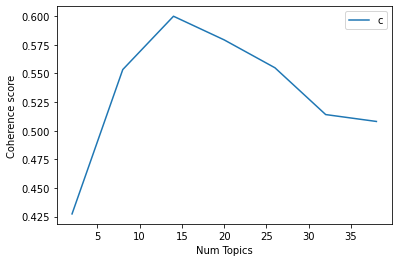

In [14]:
find_optimal_number_of_topics(dictionary, corpus, processed_data)

## 토픽에 할당된 문서 추출(Topic-Document)

In [23]:
# 참고 :
# http://bigdata.emforce.co.kr/wp-content/uploads/%EC%97%A0%ED%8F%AC%EC%8A%A4-%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%9E%A9_%ED%86%A0%ED%94%BD%EB%AA%A8%EB%8D%B8%EB%A7%81LDA%EB%B0%A9%EB%B2%95%EB%A1%A0-%EC%A0%95%EB%A6%AC.pdf

def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()
    
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        
        for j, (topic_num, prop_topic) in enumerate(doc):
            if j==0:
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_list]), ignore_index=True)
            else:
                break
    return (topic_table)

In [ ]:
topictable = make_topictable_per_doc(ldamodel, corpus)
topictable = topictable.reset_index()
topictable.columns = ['문서번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중(gamma)', '각 토픽의 비중']
topictable.to_csv("post-data/lda_gamma.csv", mode='w')

## 토픽에 할당된 키워드 추출(Topic-Keyword)

In [ ]:
# topicid (int) – The ID of the topic to be returned
# topn (int, optional) – Number of the most significant words that are associated with the topic.

kk=ldamodel.show_topic(topicid=7, topn=80000)
len(kk)
# kk2=pd.DataFrame(kk)
# kk2